# Hotel reviews - text classification

Goal of this project is to build classifier which would tell if hotel is recommended to stay in or not based on review text. 

Every hotel is given review (text) and rating either on scale 1 to 5 or 1 to 10 and so it was required to harmonize scales to single one. 1 to 5 was chosen. If hotel get score 4 or 5 it is recommended for booking, otherwise not.

Training dataset contains information about hotel name, its location (lat, lon, state, city, street etc.), rating given by reviewer, review text and title and some more.

Data was obtained at https://data.world/datafiniti/hotel-reviews and provided by Datafiniti's Business Database.


In [1]:
import pandas as pd
import numpy as np

from langdetect import detect

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from collections import OrderedDict, Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import plot_model

from IPython.display import display, Image

#import pickle

C:\Users\Michal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Clean raw data

Fist it is necesary to clean up raw data to dataset which could be further enhanced / adjusted for training.

In [2]:
raw_df = pd.read_csv('datafiniti-hotel-reviews_7282_1.csv')

In [3]:
raw_df.head()

,address,categories,city,country,latitude,longitude,name,postalcode,province,reviews_date,reviews_dateadded,reviews_dorecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_usercity,reviews_username,reviews_userprovince,location
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,POINT(12.376187 45.421611)
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,POINT(12.376187 45.421611)
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,POINT(12.376187 45.421611)
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,POINT(12.376187 45.421611)
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,POINT(12.376187 45.421611)


In [4]:
raw_df.shape

(35912, 20)

Raw dataset has almost 36 thousands records and 20 columns.

Let's define focus columns - reviews_text which will be feature and reviews_rating which will be base for label.

In [5]:
focus_cols=[ 'reviews_rating' , 'reviews_text' ]

Inspect ratings distribution.

In [6]:
raw_df.reviews_rating.value_counts()

5.0     12671
4.0      9755
3.0      5708
1.0      3068
2.0      2979
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
7.9        24
7.5        24
8.8        24
4.2        22
3.4        17
4.1        14
6.3        14
7.1        13
4.5        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
4.4         6
3.3         6
4.7         6
4.9         6
2.4         4
2.5         3
3.8         3
3.7         2
3.2         2
3.9         2
2.8         1
1.3         1
9.5         1
1.5         1
6.0         1
2.9         1
7.0         1
Name: reviews_rating, dtype: int64

It is clear that there are more scales used for rating score this need to be addressed.

Establish 5 major rating categories.

In [7]:
valid_reviews_rating=[ 1.0, 2.0, 3.0, 4.0, 5.0 ]

Vast majority of records use 1-5 scale. Question is: could some values from interval <1,5> belong to sale 1-10?

Let's drop columns with NaN and 0.0 values first.

In [8]:
raw_df.dropna(subset=['reviews_rating'], inplace=True)

raw_df = raw_df[ raw_df['reviews_rating'] != 0.0 ]

Now try to assign scaling into newly created column, pick ratings which are at first sight not member of 1-5 scale and assign to each record.

In [9]:
raw_df['rating_scale_'] = ''

raw_df.loc[ ~raw_df.reviews_rating.isin( valid_reviews_rating ) ,'rating_scale_'] = '1-10'

Create so called 'identity' helper column which will identify each hotel by combination of its parameters so it is possible to check how many rating scales were used for particular hotel (e.g. if 1-10 and other, this makes 2), if more than 1 then this is recognized as an issue and such records will be dropped.

In [10]:
def encode_identity( r ):
    rtn = ''
    identity_columns = [ 'city','country','latitude','longitude','name','postalcode','province' ]
    for ic in identity_columns:
        rtn += str( r[ic] )
    return rtn

raw_df['identity_'] = raw_df.apply( lambda r: encode_identity(r), axis=1)

Get amount of scales used for each hotel ...

In [11]:
df_check_various_scales = raw_df.groupby('identity_')[ ['rating_scale_'] ].nunique()

... and exclude records for such hotels completely from dataset

In [12]:
problematic_identities = df_check_various_scales[ df_check_various_scales.rating_scale_!=1 ].index.tolist()

raw_df = raw_df [ ~raw_df['identity_'].isin( problematic_identities ) ]

Keep only ratings with 1-5 scale.

In [13]:
raw_df = raw_df [ raw_df['reviews_rating'].isin( valid_reviews_rating ) ]

Finally, extract only focus columns and drop any remaining N/A (missing) value.

In [14]:
raw_df = raw_df [ focus_cols ]

#raw_df.isnull().sum()
raw_df.dropna(subset=['reviews_text'], inplace=True)

Now check if there are any reiews with multiple rating values, i.g. same exact text would be given 2.0 and 3.0. If such reviews are found then remove them.

In [15]:
df_check_various_ratings_for_same_text = raw_df.groupby('reviews_text')[ ['reviews_rating'] ].nunique()

problematic_reviews = df_check_various_ratings_for_same_text[ df_check_various_ratings_for_same_text.reviews_rating!=1 ].index.tolist()

raw_df = raw_df [ ~raw_df['reviews_text'].isin( problematic_reviews ) ]

Only select review text with sufficient length, it also should not be too long. At least 100 characters is required and 600 characters at most allowed. This could be adjsuted in the future to potentally tweak classifier accuracy.

In [16]:
INTERVAL_L = 100
INTERVAL_U = 600

raw_df = raw_df[ ( raw_df['reviews_text'].str.len()> INTERVAL_L ) & ( raw_df['reviews_text'].str.len()<INTERVAL_U ) ]

As explained at the beginning, when hotel get rating score 4 and 5 it is recommended for booking, or with ther words staying in. 

New column is defined with name 'stay_not_stay' with 1 and 0 values. 1 means stay, 0 not stay. This column is ultimate label for classifier model.

In [17]:
def encode_stay(r):
    if r['reviews_rating'] in [ 1.0, 2.0, 3.0 ]:
        return 0
    return 1

raw_df['stay_not_stay'] = raw_df.apply( lambda r: encode_stay(r), axis=1 )

This classifier will work with English language only, hence dataset needs to exclude other languages.

In [18]:
def detect_lang(x):
    try:
        rtn = detect(x)
    except:
        rtn = ''
    return rtn

raw_df["review_language"] = raw_df['reviews_text'].apply(lambda x: detect_lang(x))

raw_df = raw_df[ raw_df["review_language"]=="en" ]

Finally, save data to CSV file which can be accessed anytime later.

In [19]:
raw_df.to_csv('datafiniti-hotel-reviews_7282_1_filtered.csv', index=False)

## Preparing data for training

Cleaned dataset needs further transformations so it is prepared for classifier training.

In [20]:
data_filtered = pd.read_csv('datafiniti-hotel-reviews_7282_1_filtered.csv')

data_filtered.head()

,reviews_rating,reviews_text,stay_not_stay,review_language
0,4.0,Pleasant 10 min walk along the sea front to th...,1,en
1,5.0,Really lovely hotel. Stayed on the very top fl...,1,en
2,5.0,We stayed here for four nights in October. The...,1,en
3,5.0,We stayed here for four nights in October. The...,1,en
4,5.0,We loved staying on the island of Lido! You ne...,1,en


Following adjustments in text are required:
- remove stop words (e.g. a, in, the ...)
- lemmatize words (i.e. remove inflectional endings and return the base of a word)
- remove digits
- remove punctuations
- remove obvious words specific to domain (in this case hotel, room etc.)
- set all words to lowercase

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_stop_words(words):
    global stop_words
    return [w for w in words if w not in stop_words]

def remove_punctuation_and_lower(s):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s.lower()

def remove_numbers(words):
    return [ w for w in words if not str.isnumeric(w) ]

def reconsturct_string(words):
    return ' '.join(words)

def lemmatize_words(words):    
    return [ lemmatizer.lemmatize(w) for w in words ]

'''
def stem_words(words):
    rtn = []
    for w in words:
        rtn.append(ps.stem(w))
    return(rtn)
'''

def remove_domain_words(words):
    domain_words = [ "room",  "hotel", "stay" ]
    return [w for w in words if w not in domain_words]

def transform_text_for_training(raw_str):
    raw_str = remove_punctuation_and_lower(raw_str)
    lst = word_tokenize(raw_str)
    lst = remove_stop_words(lst)
    lst = remove_numbers(lst)    
    #lst = stem_words(lst)
    lst = lemmatize_words(lst)
    lst = remove_domain_words(lst)
    return reconsturct_string(lst)

In [22]:
data_filtered['reviews_text2'] = data_filtered['reviews_text'].apply(lambda x: transform_text_for_training(x))

data_filtered.head()

,reviews_rating,reviews_text,stay_not_stay,review_language,reviews_text2
0,4.0,Pleasant 10 min walk along the sea front to th...,1,en,pleasant min walk along sea front water bus re...
1,5.0,Really lovely hotel. Stayed on the very top fl...,1,en,really lovely stayed top floor surprised jacuz...
2,5.0,We stayed here for four nights in October. The...,1,en,stayed four night october staff welcoming frie...
3,5.0,We stayed here for four nights in October. The...,1,en,stayed four night october staff welcoming frie...
4,5.0,We loved staying on the island of Lido! You ne...,1,en,loved staying island lido need take water veni...


In [23]:
data_filtered.to_csv('datafiniti-hotel-reviews_7282_1_preprocessed.csv', index=False)

In [24]:
df_clean = pd.read_csv('datafiniti-hotel-reviews_7282_1_preprocessed.csv')

Let's check on distribution of data to detect potential skew which could mess up training.

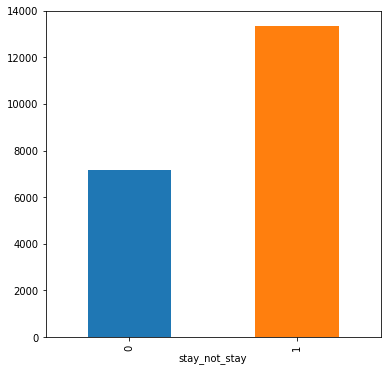

In [25]:
fig = plt.figure(figsize=(6,6))

df_clean.groupby('stay_not_stay').reviews_rating.count().plot.bar(ylim=0)
plt.show()

There are twice as much positive than negative answers, so there is risk of bias which should be addressed e.g. by resampling of training dataset and pick same amount from each group.

In [26]:
data_all = df_clean.reindex( np.random.permutation(df_clean.index) )

data_0 = data_all[ data_all["stay_not_stay"]== 0 ]
data_1 = data_all[ data_all["stay_not_stay"]== 1 ][:len(data_0)]

data = pd.concat( [data_0, data_1], axis=0)
data = data.reindex( np.random.permutation(data.index) )

Build all features and labels repository.

In [27]:
tfidf_transformer = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5, # word must appear at least in 5 documents
    norm='l2')

features = tfidf_transformer.fit_transform(data.reviews_text2).toarray()
labels = data.stay_not_stay

Split data to training and testing sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split( data.reviews_text2, labels, random_state = 32)

Transform X sets, i.e. feature sets with TFIDF vectorizer in comvination with Count vectorizer.

This would transform raw text in form of a words separated by space to sparse matrix where each word is represented by numeric value, TFIDF is short for frequency–inverse document frequency and so it assigns score to each word based on its occurencies in given 'document' or text text review.

Text features need to use same fit of Count vectorizer to ensure same length of sparse matrix as train set.

In [29]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test = tfidf_transformer.fit_transform(X_test_counts)

## Classifier training

Data is ready for training, question is which algorithm is the best, or would it be combination of multiple?

For text classification where feature is basically many feature columns (as numerical repre. of text) multinomial Naive Bayes could work, as well as Support Vetor Machines and Logistic Regressor.

Each performs well, but gives slightlty different results and so combined classifier is created which will work on voting principle. Every classifier wil put its decission (vote) on certain feature set, and classification with the most votes is chosen as final one.

### Combined classifier (Naive Bayes, Logistic Regression, SVMs)

In [30]:
MNB_classifier = MultinomialNB().fit(X_train, y_train)

In [31]:
SVC_classifier = SVC( cache_size=800 )
SVC_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
LinearSVC_classifier = LinearSVC()
LinearSVC_classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [33]:
LR_classifier = LogisticRegression(n_jobs=8, solver='sag')
LR_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=8,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
class combinedClassifier():
    
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify_one(self, features):
        votes = []
        for c in self._classifiers:
            v = c.predict(features)   
            
            votes.append(v[0])        
      
        mc = Counter(votes).most_common(1)[0]

        return mc[0]
    
    def predict(self, features):
        predictions_calc = np.zeros( ( features.shape[0], len(self._classifiers) ) )
        rtn = np.zeros( features.shape[0] )
        for i, c in enumerate( self._classifiers ):
            predictions_calc[:,i] = c.predict(features)
        
        for i in range(predictions_calc.shape[0]):
            mc = Counter( predictions_calc[i] ).most_common(1)[0]
            rtn[i] = mc[0]
            
        return rtn

In [35]:
cc = combinedClassifier( 
    MNB_classifier,
    SVC_classifier,
    LR_classifier,
    LinearSVC_classifier
)

Now predict / classify on test feature set.

In [36]:
y_pred = cc.predict(X_test)

Besides algorithms mentioned above, there could another approach taken - deep learning, or use of neural network.

## Deep learning

Data prep. follows the same principle as before - TFIDF vectorization is used for features (however different algorithm is used) and data is split to train & test, however, in this case vocabulary for tokenization is cut to 6000 words only, i.e. vocabulary is smaller, hence feature matrix is smaller.

Various iterations of training proved that neural network gives better metrics (precission, recall) if full data set is used, and so no resampling is done in this case.

In [37]:
df_clean = df_clean.reindex( np.random.permutation(df_clean.index) )

In [38]:
# lets take 80% data as training and remaining 20% for test.
TRAIN_SIZE = int(len(data) * .8)

train_features = df_clean['reviews_text2'][:TRAIN_SIZE]
train_labels = df_clean['stay_not_stay'][:TRAIN_SIZE]
 
test_features = df_clean['reviews_text2'][TRAIN_SIZE:]
test_labels = df_clean['stay_not_stay'][TRAIN_SIZE:]

In [39]:
VOCAB_SIZE = 6000
 
tokenizer = Tokenizer( num_words = VOCAB_SIZE )
tokenizer.fit_on_texts(train_features)
 
X_train2 = tokenizer.texts_to_matrix(train_features, mode='tfidf')
X_test2 = tokenizer.texts_to_matrix(test_features, mode='tfidf')
 
y_train2 = train_labels
y_test2 = test_labels

Let's look into vocabulary which will be used for training of neural network a bit closer.

In [40]:
wc = tokenizer.word_counts

df_vobac = OrderedDict([ 
         (  'word', list(wc.keys())  ),
         (  'vol', list(wc.values()) )
        ])
df_vobac = pd.DataFrame.from_dict(df_vobac)

df_vobac_sorted = df_vobac.sort_values('vol',ascending=False)
df_vobac_sorted.head(10)

,word,vol
242,staff,3888
127,clean,3839
22,great,3340
94,breakfast,3277
2,nice,3126
16,good,2644
227,night,2196
36,bed,2191
278,friendly,2140
249,would,2080


Dense neural network with two hidden layers and one embeddig is chosen. 
Embedding could be obtain from other pre-trained models for English language, but it could be also trained with specific dataset as in this case. Embedding maps relationship between words in multidimensional linear space and thus help neural network to understand distance in meaning of spec. words.

In [41]:
def define_nn ():
    
    Max_input_length = VOCAB_SIZE
    
    model = Sequential()

    model.add( Embedding(10000, 32, input_length=Max_input_length ) )
    model.add( Flatten() )
    model.add( Dropout(0.3))

    model.add( Dense(128) )
    model.add( Activation('relu') )
    model.add( Dropout(0.3) )

    model.add( Dense(16) )
    model.add( Activation('relu') )   

    #model.add(Dense( 5, activation='softmax')) #softmax is good for more classes
    model.add(Dense( 1, activation='sigmoid')) #sigmoid for binary

    return model

Let's see model summary, and amount of total parameters which will be trained.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6000, 32)          320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 192000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24576128  
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
__________

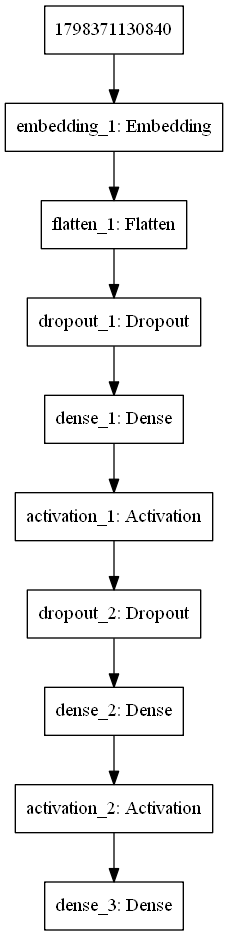

In [42]:
model = define_nn()
print(model.summary())

plot_model(model, to_file='nn_visual.png')
img = Image(filename='nn_visual.png')
display(img)

In [43]:
model.compile( loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'] )

history = model.fit(  X_train2, y_train2,
                    batch_size=100,
                    epochs=4,
                    verbose=1,
                    validation_split=0.2
                   )

Train on 9186 samples, validate on 2297 samples
Epoch 1/4
9186/9186 [==============================] - 13s 1ms/step - loss: 0.6870 - binary_accuracy: 0.6288 - val_loss: 0.6457 - val_binary_accuracy: 0.6556
Epoch 2/4
9186/9186 [==============================] - 8s 917us/step - loss: 0.6404 - binary_accuracy: 0.6482 - val_loss: 0.6112 - val_binary_accuracy: 0.6556
Epoch 3/4
9186/9186 [==============================] - 8s 920us/step - loss: 0.5090 - binary_accuracy: 0.7536 - val_loss: 0.4172 - val_binary_accuracy: 0.8163
Epoch 4/4
9186/9186 [==============================] - 8s 918us/step - loss: 0.3939 - binary_accuracy: 0.8340 - val_loss: 0.3841 - val_binary_accuracy: 0.8341


Quick evaluation before running full metrics.

In [44]:
score = model.evaluate([ X_test2 ], y_test2, batch_size=100, verbose=1) 
print('Accuracy:', score[1]) 

9019/9019 [==============================] - 1s 133us/step
Accuracy: 0.829581992604249


Predict values on test features.

In [45]:
predictions = model.predict([X_test2], verbose=1)
y_pred2 = [ 1 if x>0.5 else 0 for x in predictions  ]

#diffs = abs( y_pred2 - test_labels.values )
#print ('Accuracy:', 1 - diffs.sum() / len(predictions))

9019/9019 [==============================] - 2s 169us/step


## Evaluate model

Let's see how model performed.

As this is classification problem, metrics such as confusion matrix, recall, precission, ROC/AUC curve are chosen for evaluation. 
- Recall answers question about what proportion of actual positives was identified correctly.
- Precission measures proportion of positive identifications beiging actually correct.
- AUC represents the probability that a random positive example is positioned to the right of a random negative example on sorted scale of prbabilities, it ranges value on interval from 0 to 1, model whose predictions are 100% wrong has an AUC of 0.0 one whose predictions are 100% correct has an AUC of 1.0.

In context of the problem, classifying hotel as positive while in fact being negative is worst option, and so ideal solution would show high precission or at least both metics being in balance.

In [59]:
def classifier_evaluate(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred )
    df_cm = pd.DataFrame(cm, index = ['not stay','stay'], columns = ['pred: not stay','pred: stay'] )
    
    print( 'Confusion matrix:' )
    print( df_cm )
    print(' ')
    
    tn, fp, fn, tp =  confusion_matrix(y_test, y_pred ).ravel()
    recall = tp / (tp + fn)
    precission = tp / (tp + fp)
    accuracy = (tp + tn) / len(y_test)
    
    print('Classifier metrics:')
    print ('TRUE negatives', tn,'/ FALSE positives', fp, '/ FALSE negatives', fn,'/ TRUE positives', tp ) 
    print('Recall %', round(recall*100,2)) 
    print('Precission %', round(precission*100,2))
    print('Accuracy %', round(accuracy*100,2))
    
def show_roc_curve(y_test, y_pred):

    y_test_ = np.array( pd.get_dummies( pd.Series( y_test ) ) )
    y_pred_ = np.array( pd.get_dummies( pd.Series( y_pred ) ) )

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_class = 2
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], y_pred_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC curve and ROC area
    fpr["m"], tpr["m"], _ = roc_curve(y_test_.ravel(), y_pred_.ravel())
    roc_auc["m"] = auc(fpr["m"], tpr["m"])

    plt.figure(figsize = (8,8))
    plt.plot(fpr[1], tpr[1], color='red', label='ROC curve (area %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()

    plt.show()

## Results

Results from combined model (MNB, LR, SVMs)

Confusion matrix:
          pred: not stay  pred: stay
not stay            1540         231
stay                 346        1472
 
Classifier metrics:
TRUE negatives 1540 / FALSE positives 231 / FALSE negatives 346 / TRUE positives 1472
Recall % 80.97
Precission % 86.44
Accuracy % 83.92


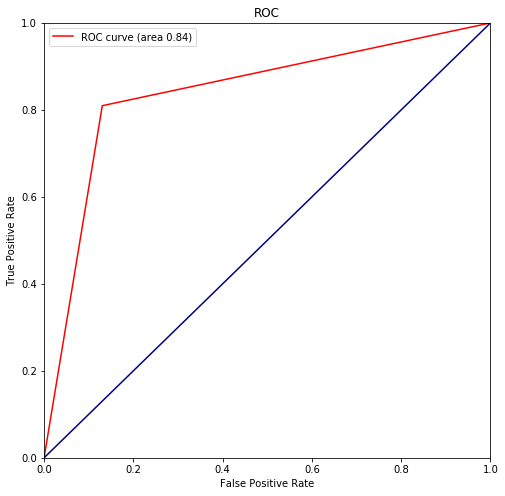

In [60]:
classifier_evaluate(y_test, y_pred)

show_roc_curve(y_test, y_pred)

Results from deep learning model.

Confusion matrix:
          pred: not stay  pred: stay
not stay            2219         956
stay                 581        5263
 
Classifier metrics:
TRUE negatives 2219 / FALSE positives 956 / FALSE negatives 581 / TRUE positives 5263
Recall % 90.06
Precission % 84.63
Accuracy % 82.96


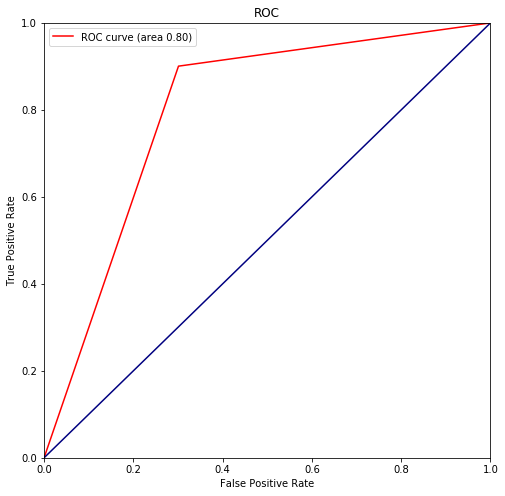

In [61]:
classifier_evaluate(y_test2, y_pred2)

show_roc_curve(y_test2, y_pred2)

By comparing both solutions, it is clear that deep learning model performed better despite of slightly lower accruacy as it provided higher precission.